# Atividade 2

Planejamento de Sistemas Elétricos - PPEE

Aluno: Alexandre Soares Altgott

Matrícula: 102100645

## Dados de entrada

In [179]:
l_usinas = []


usina = {
    "Nome": "UHE_1", # Nome da Usina
    "Tipo": "Hidreletrica",   # Tipo de Usina
    "Associada": None,        # Usina anterior a esta
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "Prod": 0.95,             # Produtibilidade em MWmed/hm^3
    "Engol": 60.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 23, 16],
            [ 19, 14],
            [ 15, 11]
    ]
}

l_usinas.append(usina)

# usina = {
#     "Nome": "UHE_2", # Nome da Usina
#     "Tipo": "Hidreletrica",   # Tipo de Usina
#     "Associada": "UHE_1",     # Usina anterior a esta     
#     "Vmax": 100.,             # Volume Máximo em hm^3
#     "Vmin": 20.,              # Volume Mínimo em hm^3
#     "Prod": 0.90,             # Produtibilidade em MWmed/hm^3
#     "Engol": 80.,             # Engolimento Máximo em hm^3
#     "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
#             [ 20, 15],
#             [ 17, 15],
#             [ 19, 14]
#     ]
# }

# l_usinas.append(usina)


# usina = {
#    "Nome": "UHE DO VASCAO",
#    "Tipo": "Hidreletrica",  
#    "Associada": None, 
#    "Vmax": 200.,
#    "Vmin": 40.,
#    "Prod": 0.85,
#    "Engol": 100.,
#    "Afl": [
#            [ 46, 32],
#            [ 38, 28],
#            [ 30, 22]
#    ]
# }
# l_usinas.append(usina)

usina = {
    "Nome": "GT_1",     # Nome da Usina Térmica 1
    "Tipo": "Termica",  # Tipo de Usina
    "Capac": 15.,       # Capacidade Máxima de Geração MWMed
    "Custo": 10.        # Custo de Operação $/MWMed
}

l_usinas.append(usina)

usina = {
    "Nome": "GT_2",     # Nome da Usina Térmica 2
    "Tipo": "Termica",  # Tipo de Usina
    "Capac": 10.,       # Capacidade Máxima de Geração MWMed
    "Custo": 25.        # Custo de Operação $/MWMed
}

l_usinas.append(usina)


d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    "Carga": [ 50., 50., 50.],  # Lista com carga a ser atendida por estágio
    # "Carga": [ 100., 100., 100.],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 15,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

sistema = {
    "DGer": d_gerais,
    "Usinas": l_usinas
}

## Objetivo

O objetivo é aplicar o PL Único ao problema estabelecido e compará-lo à PDE Adaptada feita anteriormente. para isso foi feito dois casos, o primeiro considerando apenas uma usina hidrelétrica e depois utilizando duas que são independentes entre si. Para a implementação é utilizado o Gurobipy para resolver o problema.

## Modelo Generalizado para Otimização

**Criação de uma Função para o Despacho Hidrotérmico**

$		Min \sum_{i=1}^{Nr\_EST} \left( \left( \sum_{j=1}^{Nr\_UTE}  CO_j \cdot gt_{i,j}\right) + CDEF \cdot def_{i} + \left( \sum_{j=1}^{Nr\_UHE}  0.01 \cdot vv_{i,j}\right) \right) $

**sujeito a:**

**Balanço Hídrico (uma restrição para cada estágio $i$ e UHE $j$)**

Caso $ i == 1 $:

$ v_{f_{1,j}} = VI_j + AFL_{1,j} - v_{t_{1,j}} - v_{v_{1,j}} $

Caso $ i \ge 2 $:

$ v_{f_{i,j}} = v_{f_{i-1,j}} + AFL_{i,j} - v_{t_{i,j}} - v_{v_{i,j}} $

**Atendimento à Demanda (uma restrição para cada estágio $i$)**

$ \sum_{j}^{Num\_UHE} \left( \rho_j \cdot v_{t_{i,j}} \right) +
				\sum_{j}^{Num\_UTE}	\left( g_{t_{i,j}} \right) + def_i = CARGA_i $

**Restrições de Canalização:**

Para cada estágio $i$ e UHE $j$:

$VMIN_j \ge v_{f_{i,j}} \ge VMAX_j $

$0 \ge v_{t_{i,j}} \ge ENGOL_j$

$0 \ge v_{v_{i,j}} \ge \infty $

Para cada estágio $i$ e UTE $j$:

$0 \ge g_{t_{i,j}} \ge GTMAX_j $

Para cada estágio $i$:

$ 0 \ge def_i \ge \infty $

In [180]:
import gurobipy as gp

def pl_unico(sistema, VI, cenario, imprime):

    n_UHE = 0
    n_UTE = 0

    # Calcula o numero de usinas de cada tipo
    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            n_UHE +=1

        elif usi['Tipo'] == "Termica":

            n_UTE +=1

    m = gp.Model()
    m.Params.LogToConsole = 0

    vf = []
    vt = []
    vv = []
    gt = []


    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            # Volume Final
            vf.append(m.addVars(n_UHE*sistema["DGer"]["Nr_Est"], name="Volume Final na Usina" + usi["Nome"]))

            # Volume Turbinado
            vt.append(m.addVars(n_UHE*sistema["DGer"]["Nr_Est"], name="Volume Turbinado na Usina" + usi["Nome"]))

            # Volume Vertido
            vv.append(m.addVars(n_UHE*sistema["DGer"]["Nr_Est"], name="Volume Vertido na Usina" + usi["Nome"]))

        elif usi['Tipo'] == "Termica":

            # Geração Térmica
            gt.append(m.addVars(n_UTE*sistema["DGer"]["Nr_Est"], name="Volume Final na Usina" + usi["Nome"]))

    # Deficit
    defic = m.addVars(sistema["DGer"]["Nr_Est"], name="Deficit")

    


    m.update()

    # Função Objetivo

    fob = 0

    

    # Adiciona as parcelas da FOB
    for i_est in range(sistema["DGer"]["Nr_Est"]):

        term = 0
        hidre = 0

        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                fob += 0.01*vv[hidre][i_est]
                usi['Numero'] = hidre
                hidre += 1

            elif usi['Tipo'] == "Termica": 

                fob += usi['Custo']*gt[term][i_est]
                term += 1

        fob += sistema["DGer"]["CDef"]*defic[i_est]

    

    m.setObjective(fob, gp.GRB.MINIMIZE)

    # Adiciona as restrições de balanço hídrico e monta a equação de atendimento a demanda

    for i_est in range(sistema["DGer"]["Nr_Est"]):

        term = 0
        hidre = 0
        AD = 0

        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica" and usi['Associada'] == None:

                if i_est == 0:

                    names = "c" + str(hidre+1) + str(i_est+1) 
                    m.addConstr(vf[hidre][i_est] == float(VI[hidre]) + float(usi['Afl'][i_est][cenario]) - vt[hidre][i_est] - vv[hidre][i_est], name=names)
                    m.update()
                    AD += usi["Prod"]*vt[hidre][i_est]
                    hidre += 1

                else:

                    names = "c" + str(hidre+1) + str(i_est+1) 
                    m.addConstr(vf[hidre][i_est] == vf[hidre][i_est-1] + float(usi['Afl'][i_est][cenario]) - vt[hidre][i_est] - vv[hidre][i_est], name=names)
                    m.update()
                    AD += usi["Prod"]*vt[hidre][i_est]
                    hidre += 1

            elif usi['Tipo'] == "Hidreletrica" and usi['Associada'] != None:

                for  usi2 in sistema["Usinas"]:

                    if usi['Associada'] == usi2['Nome']:

                        if i_est == 0:

                            names = "c" + str(hidre+1) + str(i_est+1) 
                            m.addConstr(vf[hidre] == float(VI[hidre])  + float(usi['Afl'][i_est][cenario]) - vt[hidre][i_est] - vv[hidre][i_est] + vt[usi2['Numero']][i_est] + vv[usi2['Numero']][i_est], name=names)
                            m.update()
                            AD += usi["Prod"]*vt[hidre][i_est] 

                        else:
                            
                            names = "c" + str(hidre+1) + str(i_est+1) 
                            m.addConstr(vf[hidre] == vf[hidre][i_est-1]  + float(usi['Afl'][i_est][cenario]) - vt[hidre][i_est] - vv[hidre][i_est] + vt[usi2['Numero']][i_est] + vv[usi2['Numero']][i_est], name=names)
                            m.update()
                            AD += usi["Prod"]*vt[hidre][i_est] 

                hidre += 1

            elif usi['Tipo'] == "Termica":

                AD += gt[term][i_est] 
                term += 1

        AD += defic[i_est]

        # Restrição de atendimento a demanda
        m.addConstr(AD == sistema["DGer"]["Carga"][i_est], name="c0")
        m.update()



    for i_est in range(sistema["DGer"]["Nr_Est"]):

        # Restrições de canalização
        term = 0
        hidre = 0

        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                m.addConstr(vf[hidre][i_est] >= usi["Vmin"])
                m.addConstr(vf[hidre][i_est] <= usi["Vmax"])
                m.addConstr(vt[hidre][i_est] >= 0)
                m.addConstr(vt[hidre][i_est] <= usi["Engol"])
                m.addConstr(vv[hidre][i_est] >= 0)
                hidre += 1
                m.update()

            elif usi['Tipo'] == "Termica":

                m.addConstr(gt[term][i_est] <= usi["Capac"])
                m.addConstr(gt[term][i_est] >= 0)
                term += 1
                m.update()
        
        m.addConstr(defic[i_est] >= 0)

        m.update()



    # Otimiza o problema
    m.optimize()

    # Devolve o resultado necessário
    resposta = []
    hidre = 0
    resposta.append(m.objVal)

    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            for j in range(0,3):
                resposta.append([])

    hidre = 0

    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            resposta[hidre+1] = [vf[hidre][0].x,vf[hidre][1].x,vf[hidre][2].x]
            resposta[hidre+2] = vt[hidre][0].x
            resposta[hidre+3] = vv[hidre][0].x
            hidre += 1

    # for usi in sistema["Usinas"]:

    #     if usi['Tipo'] == "Hidreletrica":
    #         names = "c" + str(hidre+1)
    #         pi = m.getConstrByName(names)
    #         resposta.append(pi.Pi)
    #         hidre += 1

    # Impressão dos resultados 
    if imprime:

        print("Custo Total:", m.objVal)
        hidre = 0
        term = 0

        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                print(vf[hidre].VarName,"é",vf[hidre].x,"hm3")
                print(vt[hidre].VarName,"é",vt[hidre].x,"hm3")
                print(vv[hidre].VarName,"é",vv[hidre].x,"hm3")
                hidre += 1

            elif usi['Tipo'] == "Termica":

        
                print(gt[term].VarName,"é",gt[term].x, "MWmed")
                term += 1

        print(defic[0].VarName,"é",defic[0].x, "MWmed")

        

            

    return resposta

## Resultados

### Caso 1

Neste caso é considerado apenas uma Usina.

A seguir é plotado o custo obtido ao se variar o o volume inicial e o cenário de afluência.

Além da evolução do Volume final de cada estágio para cada volume inicial.

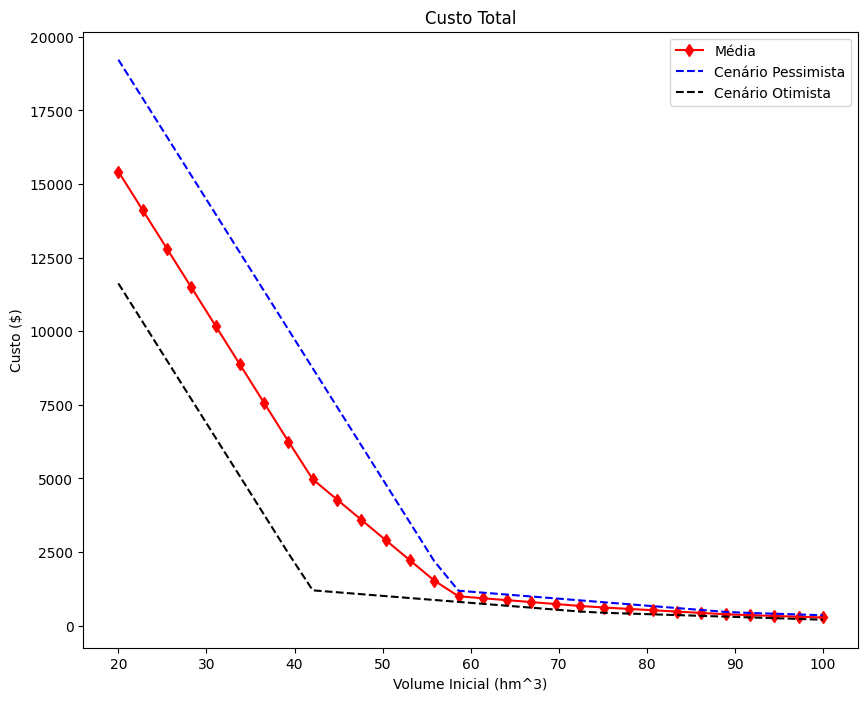

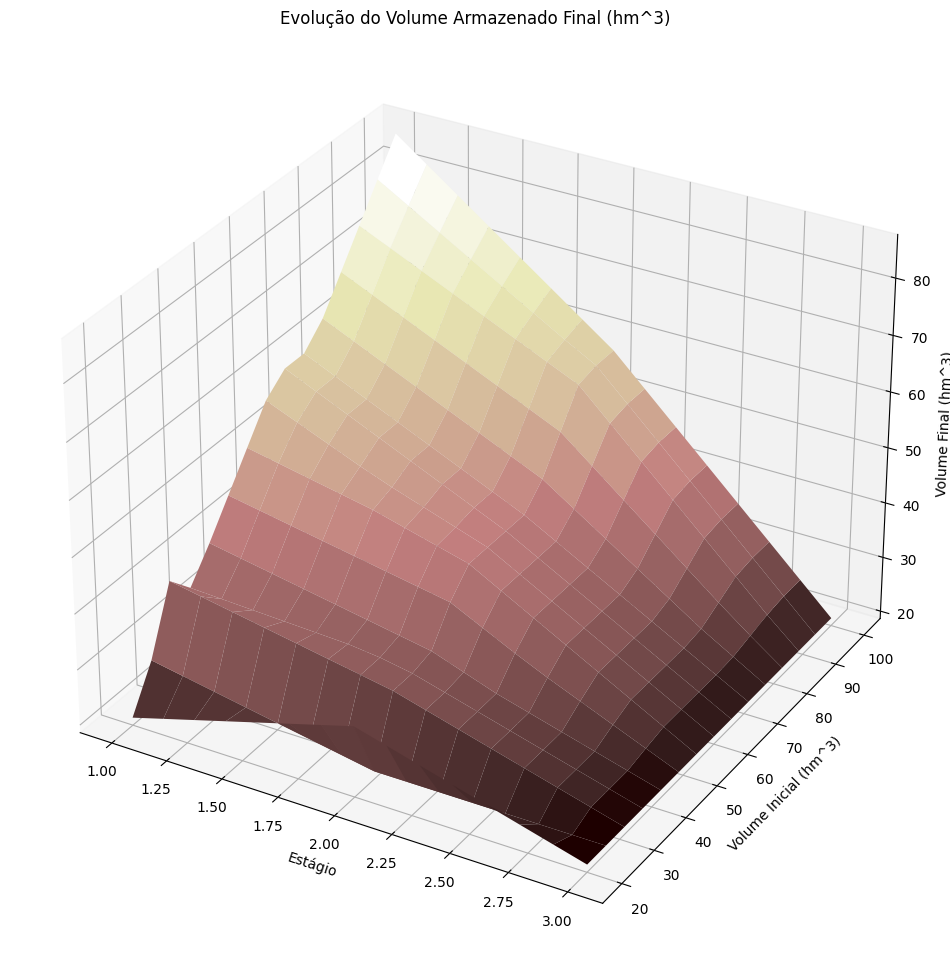

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

tempo_PL_unico = time.time()

Custo = []
CustoP = []
CustoO = []
VF1 = []

vi = np.linspace(20,100,30)


for i in vi:
    resultado1 = pl_unico(sistema, [i], 0, imprime=False)
    resultado2 = pl_unico(sistema, [i], 1, imprime=False)   
    VF1.append(resultado1[1][0])
    VF1.append(resultado1[1][1])
    VF1.append(resultado1[1][2])

    Custo.append((resultado1[0]+resultado2[0])/2)
    CustoP.append(resultado2[0])
    CustoO.append(resultado1[0])



plt.figure(figsize=(10,8))
plt.plot( vi, Custo , marker='d',color='red',label = 'Média')
plt.plot( vi, CustoP,color='blue' ,linestyle='dashed',label = 'Cenário Pessimista')
plt.plot( vi, CustoO ,color='black',linestyle='dashed',label = 'Cenário Otimista')
plt.title('Custo Total')
plt.ylabel('Custo ($)')
plt.xlabel('Volume Inicial (hm^3)')
plt.legend()

tempo_PL_unico = - tempo_PL_unico + time.time()

x1 = []
vi1 = []

for i in range(0,int(len(VF1)/3)):
    x1.append(1)
    x1.append(2)
    x1.append(3)
    vi1.append(vi[i])
    vi1.append(vi[i])
    vi1.append(vi[i])


fig = plt.figure(figsize=(12,14))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Evolução do Volume Armazenado Final (hm^3)')
ax.set_xlabel('Estágio')
ax.set_ylabel('Volume Inicial (hm^3)')
ax.set_zlabel('Volume Final (hm^3)')



plotx,ploty, = np.meshgrid(np.linspace(np.min(x1),np.max(x1),sistema["DGer"]["Nr_Disc"]),\
                           np.linspace(np.min(vi1),np.max(vi1),sistema["DGer"]["Nr_Disc"]))
plotz = interp.griddata((x1,vi1),VF1,(plotx,ploty),method='linear')

ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1, cmap=cm.pink)

## PDE Adaptado

É então executado o PDE Adaptado para que se possa fazer comparações com o PL Único

## Função para o despacho do PDE Adaptado

In [182]:
def despacho(sistema, VI, AFL, pote_de_corte, iest, imprime, n_UHE, n_UTE):


    m = gp.Model()
    m.Params.LogToConsole = 0

    # Volume Final
    vf = m.addVars(n_UHE, name="Volume Final na Usina")

    # Volume Turbinado
    vt = m.addVars(n_UHE, name="Volume Turbinado na Usina")

    # Volume Vertido
    vv = m.addVars(n_UHE, name="Volume Vertido na Usina")

    # Geração Térmica
    gt = m.addVars(n_UTE, name="Volume Final na Usina")

    # Volume Final
    defic = m.addVars(1, name="Deficit")

    # Custo Futuro
    alpha = m.addVars(1, name="Custo Futuro")

    m.update()

    # Função Objetivo

    fob = 0

    term = 0
    hidre = 0

    # Adiciona as parcelas da FOB
    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            fob += 0.01*vv[hidre]
            usi['Numero'] = hidre
            hidre += 1

        # elif usi['Tipo'] == "Hidreletrica" and usi['Associada'] != None:

        #     for  usi2 in sistema["Usinas"]:

        #         if usi['Associada'] == usi2['Nome']:

        #             fob -= 0.01*vv[usi2['Numero']]

        elif usi['Tipo'] == "Termica": 

            fob += usi['Custo']*gt[term]
            term += 1

    fob += sistema["DGer"]["CDef"]*defic[0]

    fob += 1.0*alpha[0]

    m.setObjective(fob, gp.GRB.MINIMIZE)

    # Adiciona as restrições de balanço hídrico e monta a equação de atendimento a demanda
    term = 0
    hidre = 0
    AD = 0

    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica" and usi['Associada'] == None:
            names = "c" + str(hidre+1)
            m.addConstr(vf[hidre] == float(VI[hidre]) + float(AFL[hidre]) - vt[hidre] - vv[hidre], name=names)
            m.update()
            AD += usi["Prod"]*vt[hidre]
            hidre += 1

        elif usi['Tipo'] == "Hidreletrica" and usi['Associada'] != None:

            for  usi2 in sistema["Usinas"]:

                if usi['Associada'] == usi2['Nome']:
                    names = "c" + str(hidre+1)
                    m.addConstr(vf[hidre] == float(VI[hidre]) + float(AFL[hidre]) - vt[hidre] - vv[hidre] + vt[usi2['Numero']] + vv[usi2['Numero']], name=names)
                    m.update()
                    AD += usi["Prod"]*vt[hidre]

            hidre += 1

        elif usi['Tipo'] == "Termica":

            AD += gt[term]
            term += 1

    AD += defic[0]

    # Restrição de atendimento a demanda
    m.addConstr(AD == sistema["DGer"]["Carga"][iest-1], name="c0")
    m.update()


    # Restrições de canalização
    term = 0
    hidre = 0

    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":

            m.addConstr(vf[hidre] >= usi["Vmin"])
            m.addConstr(vf[hidre] <= usi["Vmax"])
            m.addConstr(vt[hidre] >= 0)
            m.addConstr(vt[hidre] <= usi["Engol"])
            m.addConstr(vv[hidre] >= 0)
            hidre += 1
            m.update()

        elif usi['Tipo'] == "Termica":

            m.addConstr(gt[term] <= usi["Capac"])
            m.addConstr(gt[term] >= 0)
            term += 1
            m.update()
    
    m.addConstr(defic[0] >= 0)
    m.addConstr(alpha[0] >= 0)

    m.update()


    # Restrições do corte

    for icorte in pote_de_corte:

        if icorte['Estagio'] == iest+1:
            equacao = 0

            for i in range(n_UHE):

                equacao += float(icorte['Coefs'][i])*vf[i]

            equacao += float(icorte['Termo_Indep'])
            m.addConstr(alpha[0] >= equacao)
            m.update()

    m.update()

    # Otimiza o problema
    m.optimize()

    # Devolve o resultado necessário
    resposta = []
    hidre = 0
    resposta.append(m.objVal)
    for usi in sistema["Usinas"]:

        if usi['Tipo'] == "Hidreletrica":
            names = "c" + str(hidre+1)
            pi = m.getConstrByName(names)
            resposta.append(pi.Pi)
            hidre += 1

    # Impressão dos resultados 
    if imprime:

        print("Custo Total:", m.objVal)
        hidre = 0
        term = 0

        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                print(vf[hidre].VarName,"é",vf[hidre].x,"hm3")
                print(vt[hidre].VarName,"é",vt[hidre].x,"hm3")
                print(vv[hidre].VarName,"é",vv[hidre].x,"hm3")
                hidre += 1

            elif usi['Tipo'] == "Termica":

        
                print(gt[term].VarName,"é",gt[term].x, "MWmed")
                term += 1

        print(defic[0].VarName,"é",defic[0].x, "MWmed")

        print(alpha[0].VarName,"é",alpha[0].x, "$")

            

    return resposta

## Execução do PDE Adaptado

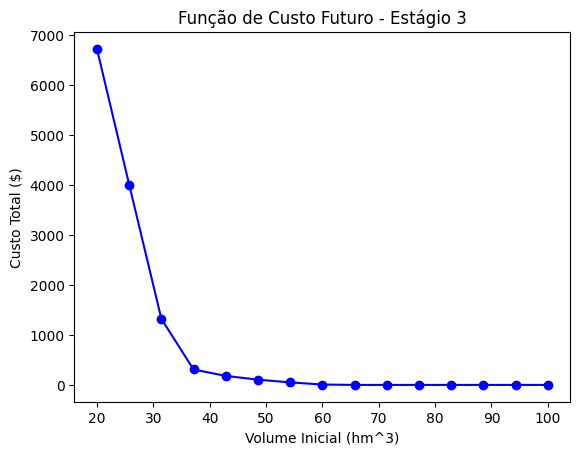

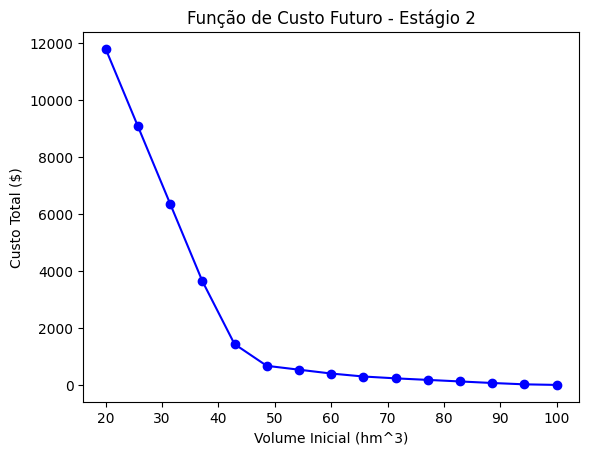

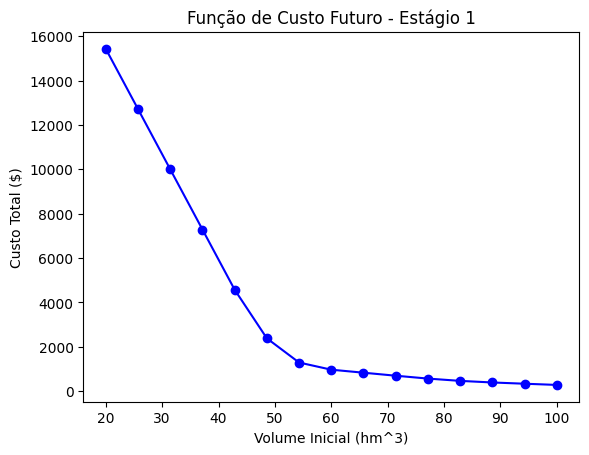

In [183]:
from itertools import product, tee
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

tempo_PDE = time.time()

n_UHE = 0
n_UTE = 0

# Calcula o numero de usinas de cada tipo
for usi in sistema["Usinas"]:

    if usi['Tipo'] == "Hidreletrica":

        n_UHE +=1

    elif usi['Tipo'] == "Termica":

        n_UTE +=1

pote_de_corte = []
imprime = 0


eixoy = []
eixox = []

# Discretiza
passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

discretizacoes = product(np.arange(0,100+passo,passo), repeat = n_UHE)

discretizacoes = list(discretizacoes)

a = np.linspace(0,100,sistema["DGer"]["Nr_Disc"])

b = np.linspace(sistema["DGer"]["Nr_Est"],1,sistema["DGer"]["Nr_Est"])

c = np.linspace(0,sistema["DGer"]["Nr_Cen"]-1,sistema["DGer"]["Nr_Cen"])

# Começa o Loop para cada estágio
for iest in b:
    iest = int(iest)

    eixoy = []
    eixox = []

    # inicia um grafico de superficie caso tenha duas UHE
    if n_UHE == 2:
        
        fig = plt.figure(iest)
        ax = fig.add_subplot(projection='3d')
        ax.set_title('Função de Custo Futuro - Estágio '+str(iest))
        ax.set_xlabel('Vol.In. UHE 1')
        ax.set_ylabel('Vol.In. UHE 2')
        ax.set_zlabel('FCF ($)')
        Usi_1 = np.arange(0,100+passo,passo)
        Usi_2 = np.arange(0,100+passo,passo)
        Usi_1, Usi_2 = np.meshgrid(Usi_1, Usi_2)
        Custos = np.zeros((sistema["DGer"]["Nr_Disc"],sistema["DGer"]["Nr_Disc"]))

    # Começa o loop para cada discretização
    for disc in discretizacoes:

        VI = []

        media_cma = []
        media = 0.
        
        hidre = 0

        # Calcula o valor de VI baseado no atual valor de discretização
        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                VI.append(usi["Vmin"] + (usi["Vmax"]-usi["Vmin"])*disc[hidre]/100)
                media_cma.append(0)
                hidre += 1

        eixox.append(VI[0])

        # Identifica os cenarios de afluencia e chama a função de despacho para resolver o problema
        for icen in np.linspace(0,sistema["DGer"]["Nr_Cen"]-1,sistema["DGer"]["Nr_Cen"]):

            AFL = []
            
            hidre = 0

            for usi in sistema["Usinas"]:

                if usi['Tipo'] == "Hidreletrica":

                    AFL.append(usi["Afl"][int(iest)-1][int(icen)])

            # Resolve o problema
            resultado = despacho(sistema,VI,AFL, pote_de_corte, int(iest), imprime, n_UHE, n_UTE)

            # Soma o resultado de custo do atual cenario para a media 
            media += resultado[0]

            # Soma o resultado de CMA do atual cenario para a media de CMA 
            for usi in sistema["Usinas"]:
                
                if usi['Tipo'] == "Hidreletrica":

                    media_cma[hidre] += -resultado[hidre+1]

            
                    hidre += 1

        # Faz a media de custo dos cenarios
        media = media/sistema["DGer"]["Nr_Cen"]

        # Organiza os resultados necessários para o grafico em caso de duas UHE
        if n_UHE == 2:

            for linha in range(sistema["DGer"]["Nr_Disc"]):

                for coluna in range(sistema["DGer"]["Nr_Disc"]):

                    if Usi_1[linha][coluna] == disc[0] and Usi_2[linha][coluna] == disc[1]:

                        Custos[linha][coluna] = media

        term_indep = media


        hidre = 0

        # Calcula os elementos para a inequação de corte
        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":
        
                media_cma[hidre] = -media_cma[hidre] / sistema["DGer"]["Nr_Cen"]
                term_indep -= VI[hidre]*media_cma[hidre]
                hidre += 1

        corte = {
            "Estagio": iest ,
            "Termo_Indep": term_indep,
            "Coefs": media_cma
        }

        pote_de_corte.append(corte)
        eixoy.append(media)
    
    # Plota o grafico de superficie para o caso de duas UHE
    if n_UHE == 2:    
        surf = ax.plot_surface(Usi_1, Usi_2, Custos, cmap=cm.jet)

    # Plota o grafico para o caso de uma UHE
    if n_UHE == 1:
        plt.figure(iest)
        plt.title("Função de Custo Futuro - Estágio "+str(iest))
        plt.xlabel("Volume Inicial (hm^3)")
        plt.ylabel("Custo Total ($)")
        plt.plot(eixox,eixoy,marker="o",color="blue")

tempo_PDE = - tempo_PDE + time.time()

## Comparação PDE x PL Único

A seguir é comparado o custo ao se plotar o custo futuro do estágio do PDE e o custo em função do volume inicial do PL único.

Tempo computacional PL Único     : 0.0669 s
Tempo computacional PDE Adaptado : 0.0851 s


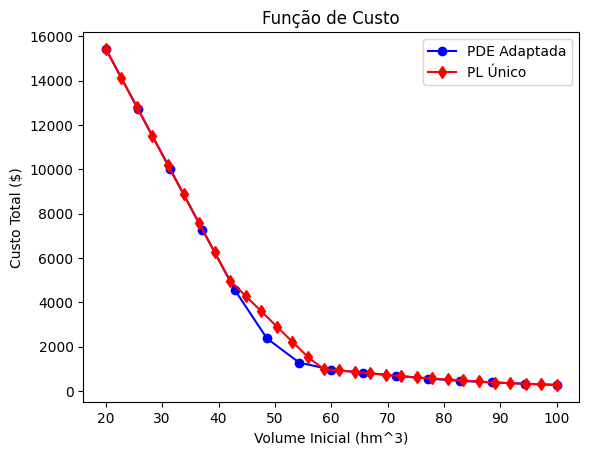

In [186]:
plt.figure()
plt.title("Função de Custo")
plt.xlabel("Volume Inicial (hm^3)")
plt.ylabel("Custo Total ($)")
plt.plot(eixox,eixoy,marker="o",color="blue",label = 'PDE Adaptada')
plt.plot( vi, Custo , marker='d',color="red",label = 'PL Único')
plt.legend()

print("Tempo computacional PL Único     : %.4f" % tempo_PL_unico, "s")
print("Tempo computacional PDE Adaptado : %.4f" % tempo_PDE ,"s")

## Caso 2

Considerando duas usinas independentes

Carrega as novas informações de carga e da nova UHE

In [187]:
usina = {
    "Nome": "UHE_2", # Nome da Usina
    "Tipo": "Hidreletrica",   # Tipo de Usina
    "Associada": None,     # Usina anterior a esta     
    "Vmax": 100.,             # Volume Máximo em hm^3
    "Vmin": 20.,              # Volume Mínimo em hm^3
    "Prod": 0.90,             # Produtibilidade em MWmed/hm^3
    "Engol": 80.,             # Engolimento Máximo em hm^3
    "Afl": [                  # Cenários de Afluências (linha: Estágio, coluna: cenário)
            [ 28, 21],
            [ 23, 19],
            [ 25, 18]
    ]
}

l_usinas.append(usina)

d_gerais = {
    "CDef": 500.,             # Custo de Déficit $/MWMed
    # "Carga": [ 50., 50., 50.],  # Lista com carga a ser atendida por estágio
    "Carga": [ 85., 85., 85.],  # Lista com carga a ser atendida por estágio
    "Nr_Disc": 15,            # Número de Discretizações
    "Nr_Est": 3,              # Número de Estágios
    "Nr_Cen": 2               # Número de Cenários de Afluências
}

sistema = {
    "DGer": d_gerais,
    "Usinas": l_usinas
}

Executa o PL Único com cenário otimista

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D

tempo_PL_unico = time.time()

n_UHE = 0
n_UTE = 0

# Calcula o numero de usinas de cada tipo
for usi in sistema["Usinas"]:

    if usi['Tipo'] == "Hidreletrica":

        n_UHE +=1

    elif usi['Tipo'] == "Termica":

        n_UTE +=1

passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

discretizacoes = product(np.arange(0,100+passo,passo), repeat = n_UHE)

discretizacoes = list(discretizacoes)

Custo = []
CustoP = []
Z = []

for i, j in discretizacoes:

    resultado1 = pl_unico(sistema, [i,j], 0, imprime=False)
    # resultado2 = pl_unico(sistema, [i,j], 1, imprime=False)

    # Custo.append((resultado1[0]+resultado2[0])/2)
    # CustoP.append(resultado2[0])
    Z.append(resultado1[0])


X = []
Y = []
for i, j in discretizacoes:
    X.append(i)
    Y.append(j)


plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),sistema["DGer"]["Nr_Disc"]),\
                           np.linspace(np.min(Y),np.max(Y),sistema["DGer"]["Nr_Disc"]))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')



# tempo_PL_unico = - tempo_PL_unico + time.time()

Executa o PDE adaptado

In [189]:
from itertools import product, tee
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

tempo_PDE = time.time()

n_UHE = 0
n_UTE = 0


# Calcula o numero de usinas de cada tipo
for usi in sistema["Usinas"]:

    if usi['Tipo'] == "Hidreletrica":

        n_UHE +=1

    elif usi['Tipo'] == "Termica":

        n_UTE +=1

pote_de_corte = []
imprime = 0


eixoy = []
eixox = []

# Discretiza
passo = 100/(sistema["DGer"]["Nr_Disc"]-1)

discretizacoes = product(np.arange(0,100+passo,passo), repeat = n_UHE)

discretizacoes = list(discretizacoes)

a = np.linspace(0,100,sistema["DGer"]["Nr_Disc"])

b = np.linspace(sistema["DGer"]["Nr_Est"],1,sistema["DGer"]["Nr_Est"])

c = np.linspace(0,sistema["DGer"]["Nr_Cen"]-1,sistema["DGer"]["Nr_Cen"])

# Começa o Loop para cada estágio
for iest in b:
    iest = int(iest)

    eixoy = []
    eixox = []

    # inicia um grafico de superficie caso tenha duas UHE
    # if n_UHE == 2 :
        
    #     fig = plt.figure(iest)
    #     ax = fig.add_subplot(projection='3d')
    #     ax.set_title('Função de Custo Futuro - Estágio '+str(iest))
    #     ax.set_xlabel('Vol.In. UHE 1')
    #     ax.set_ylabel('Vol.In. UHE 2')
    #     ax.set_zlabel('FCF ($)')
    #     Usi_1 = np.arange(0,100+passo,passo)
    #     Usi_2 = np.arange(0,100+passo,passo)
    #     Usi_1, Usi_2 = np.meshgrid(Usi_1, Usi_2)
    #     Custos = np.zeros((sistema["DGer"]["Nr_Disc"],sistema["DGer"]["Nr_Disc"]))

    # Começa o loop para cada discretização
    for disc in discretizacoes:

        VI = []

        media_cma = []
        media = 0.
        
        hidre = 0

        # Calcula o valor de VI baseado no atual valor de discretização
        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":

                VI.append(usi["Vmin"] + (usi["Vmax"]-usi["Vmin"])*disc[hidre]/100)
                media_cma.append(0)
                hidre += 1

        eixox.append(VI[0])

        # Identifica os cenarios de afluencia e chama a função de despacho para resolver o problema
        for icen in np.linspace(0,sistema["DGer"]["Nr_Cen"]-1,sistema["DGer"]["Nr_Cen"]):

            AFL = []
            
            hidre = 0

            for usi in sistema["Usinas"]:

                if usi['Tipo'] == "Hidreletrica":

                    AFL.append(usi["Afl"][int(iest)-1][int(icen)])

            # Resolve o problema
            resultado = despacho(sistema,VI,AFL, pote_de_corte, int(iest), imprime, n_UHE, n_UTE)

            # Soma o resultado de custo do atual cenario para a media 
            media += resultado[0]

            # Soma o resultado de CMA do atual cenario para a media de CMA 
            for usi in sistema["Usinas"]:
                
                if usi['Tipo'] == "Hidreletrica":

                    media_cma[hidre] += -resultado[hidre+1]

            
                    hidre += 1

        # Faz a media de custo dos cenarios
        media = media/sistema["DGer"]["Nr_Cen"]

        # Organiza os resultados necessários para o grafico em caso de duas UHE
        if n_UHE == 2:

            for linha in range(sistema["DGer"]["Nr_Disc"]):

                for coluna in range(sistema["DGer"]["Nr_Disc"]):

                    if Usi_1[linha][coluna] == disc[0] and Usi_2[linha][coluna] == disc[1]:

                        Custos[linha][coluna] = media

        term_indep = media


        hidre = 0

        # Calcula os elementos para a inequação de corte
        for usi in sistema["Usinas"]:

            if usi['Tipo'] == "Hidreletrica":
        
                media_cma[hidre] = -media_cma[hidre] / sistema["DGer"]["Nr_Cen"]
                term_indep -= VI[hidre]*media_cma[hidre]
                hidre += 1

        corte = {
            "Estagio": iest ,
            "Termo_Indep": term_indep,
            "Coefs": media_cma
        }

        pote_de_corte.append(corte)
        eixoy.append(media)
    
    # Plota o grafico de superficie para o caso de duas UHE
    # if n_UHE == 2 and iest == 1:    
        # surf = ax.plot_surface(Usi_1, Usi_2, Custos, cmap=cm.jet)

    # Plota o grafico para o caso de uma UHE
    if n_UHE == 1:
        plt.figure(iest)
        plt.title("Função de Custo Futuro - Estágio "+str(iest))
        plt.xlabel("Volume Inicial (hm^3)")
        plt.ylabel("Custo Total ($)")
        plt.plot(eixox,eixoy,marker="o",color="blue")

tempo_PDE = - tempo_PDE + time.time()




## Comparação entre os tipos de modelos de otimização

A seguir é comparado o custo ao se plotar o custo futuro do estágio do PDE e o custo em função do volume inicial do PL único.

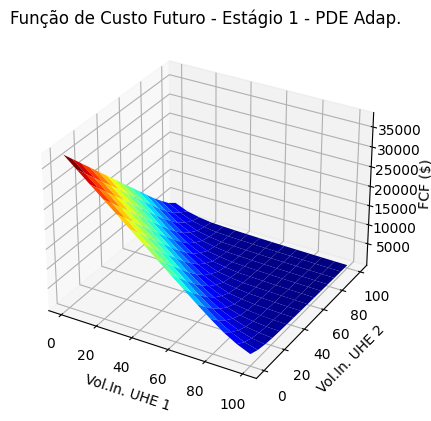

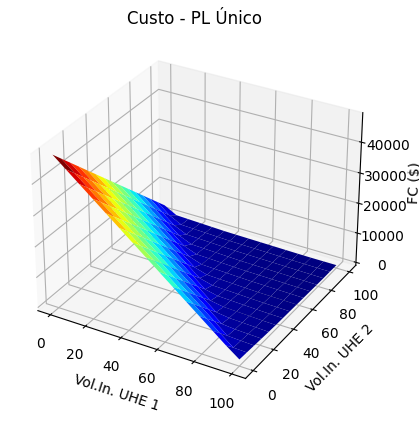

In [190]:
fig = plt.figure(iest)
ax = fig.add_subplot(projection='3d')
ax.set_title('Função de Custo Futuro - Estágio '+str(iest) + ' - PDE Adap.')
ax.set_xlabel('Vol.In. UHE 1')
ax.set_ylabel('Vol.In. UHE 2')
ax.set_zlabel('FCF ($)')
Usi_1 = np.arange(0,100+passo,passo)
Usi_2 = np.arange(0,100+passo,passo)
Usi_1, Usi_2 = np.meshgrid(Usi_1, Usi_2)
# Custos = np.zeros((sistema["DGer"]["Nr_Disc"],sistema["DGer"]["Nr_Disc"]))

surf = ax.plot_surface(Usi_1, Usi_2, Custos, cmap=cm.jet)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Custo - PL Único')
ax.set_xlabel('Vol.In. UHE 1')
ax.set_ylabel('Vol.In. UHE 2')
ax.set_zlabel('FC ($)')
ax.plot_surface(plotx,ploty,plotz,cstride=1,rstride=1, cmap=cm.jet)